In [1]:
import glob
import cv2
import numpy as np
import math
from matplotlib import gridspec
import matplotlib.pyplot as plt

In [2]:
def pim(images, titles=None, cols=0, cmap='gray', interpolation='none'):
    """Plot Image.

    Display one or more images in one row without blocking.

    Input :
        images : list of images as numpy arrays
        titles : list of title strings for each image. Default : None
        cmap : color map for showing image. Default : gray

    Output :
        Plot all images in one row with plt.show(block=False)
    """

    if type(images) != list and type(images) != np.ndarray:
        logging.warning('Input must be list or numpy array')
        return None

    N = len(images)

    if cols < 1:
        cols = len(images)
    rows = int(math.ceil(N / cols))

    if titles is None:
        titles = ['Image'] * N

    gs = gridspec.GridSpec(rows, cols)

    fheight = int(math.ceil(10 * rows / cols))

    fig = plt.figure(figsize=(14, fheight))
    for n in range(N):
        ax = fig.add_subplot(gs[n])
        ax.imshow(images[n], cmap=cmap)
        ax.set_title(titles[n] + ' ' + str(images[n].shape))

    gs.tight_layout(fig)
    plt.show()

In [3]:
class CameraCalibration(object):
    """Calibrition class to calibrate and undistort camera images using chess template.
    
    1. Run calibrate function to calibrate camera
    2. Run undistort function for undistortion
    """
    
    def calibrate(self, prefix, chess_hight, chess_width, compression='jpg'):
        """
        Load images taken by camera to be calibrated.
        
            prefix : path + common prefix for names of images
            compression : image format/extension. Default : jpg
        
        Find chess points using cv2 findChessboardCorners.
            
            chess_hight : points inside chess board to be find vertically
            chess_width : points inside chess board to be find horizontally
        """
        
        # Load all image full paths from folder.
        im_paths = glob.glob(prefix + '*.' + compression)
        objpoints, imgpoints, img_size = self.find_chess_board_corners(im_paths, chess_hight, chess_width)
        
        # Do camera calibration given object points and image points
        _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    def undistort(self, img):
        """Undistort input image using computer MTX and DIST values."""
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def find_chess_board_corners(self, im_paths, chess_hight, chess_width):
        """Find Chesboard Corners using openCV.
        
            im_paths : full image paths
            chess_hight : points inside chess board to be find vertically
            chess_width : points inside chess board to be find horizontally
        """

        # prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0) ....,(6, 5, 0)
        objp = np.zeros((chess_hight * chess_width, 3), np.float32)
        objp[:,:2] = np.mgrid[0: chess_width, 0: chess_hight].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane found by findChessBoardCorners
        
        for idx, fname in enumerate(im_paths):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (chess_width, chess_hight), None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        
        print('Chessboard found on {} images'.format(len(imgpoints)))
        return objpoints, imgpoints, (img.shape[1], img.shape[0])

Chessboard found on 134 images


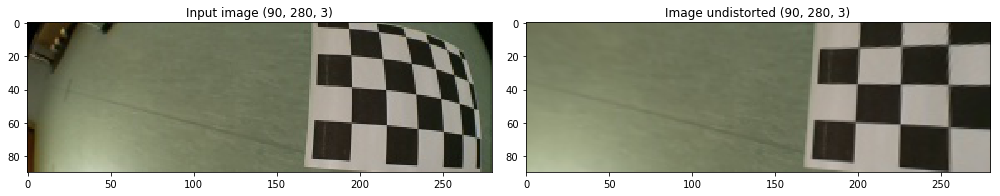

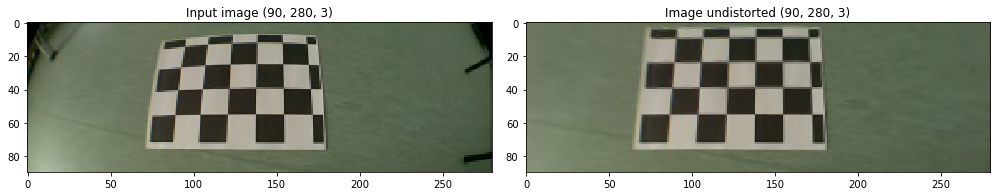

In [6]:
C = CameraCalibration()

# Calibration camera
chess_h = 3
chess_w = 5
C.calibrate('/home/nauris/Dropbox/coding/self-driving-RCcar/camera_cal/', chess_h, chess_w, compression='jpeg')

im = cv2.cvtColor(cv2.imread('camera_cal/example0.jpeg'), cv2.COLOR_BGR2RGB)
im_undistorted = C.undistort(im)
pim([im, im_undistorted], ['Input image', 'Image undistorted'])
save_im = cv2.cvtColor(np.concatenate((im, im_undistorted), axis=1), cv2.COLOR_RGB2BGR)
s = cv2.imwrite("camera_cal/undistortion_example.jpg", save_im)

im = cv2.cvtColor(cv2.imread('camera_cal/example1.jpeg'), cv2.COLOR_BGR2RGB)
im_undistorted = C.undistort(im)
pim([im, im_undistorted], ['Input image', 'Image undistorted'])
save_im = cv2.cvtColor(np.concatenate((im, im_undistorted), axis=1), cv2.COLOR_RGB2BGR)
s = cv2.imwrite("camera_cal/undistortion_example_2.jpg", save_im)

# Save MTX and DIST values for further undistortion without new callibration

In [7]:
import pickle

In [8]:
with open('calib.p', 'wb') as f:
    pickle.dump({'mtx': C.mtx, 'dist': C.dist}, f)